In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import warnings
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# create raw and dummy data frames from previous notebook

mushrooms = pd.read_csv('data/mushrooms.csv')
mushroom_dummies = pd.read_csv('data/dummy_data.csv')

In [3]:
mushroom_dummies.head()

,Unnamed: 0,class_edible,class_poisonous,cap-shape_convex,cap-shape_flat,cap-shape_knobby,cap-shape_other,cap-surface_fibrous,cap-surface_other,cap-surface_scaly,...,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,rpopulation_other,rpopulation_scattered,rpopulation_several,rpopulation_solitary
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,3,0,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,4,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [4]:
mushroom_dummies.drop(columns=['Unnamed: 0'], inplace=True)

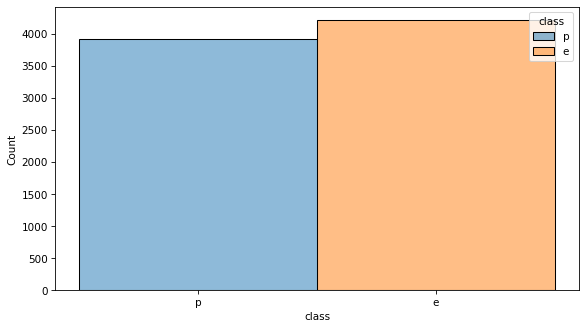

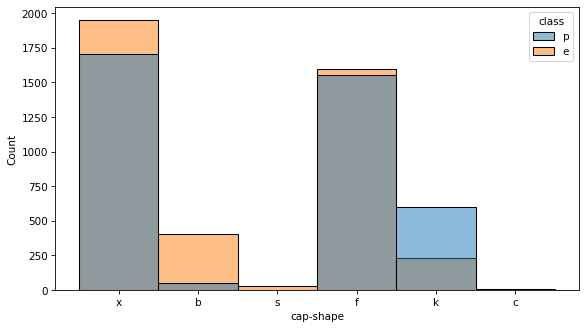

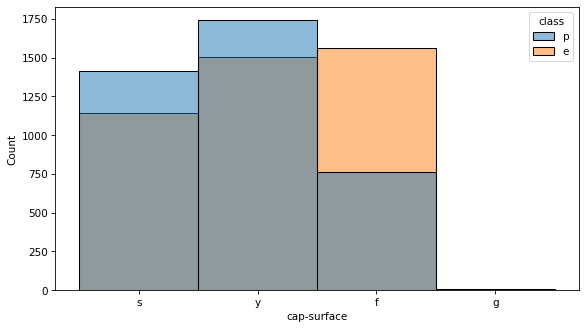

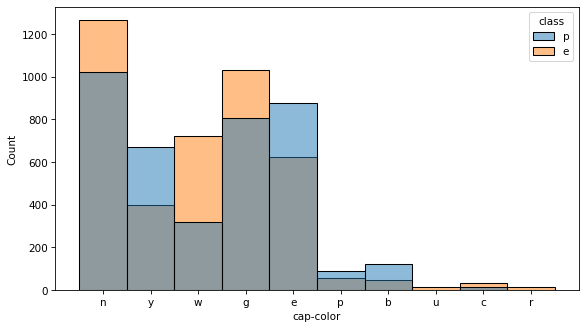

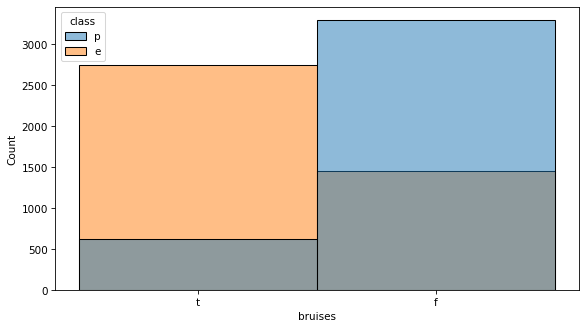

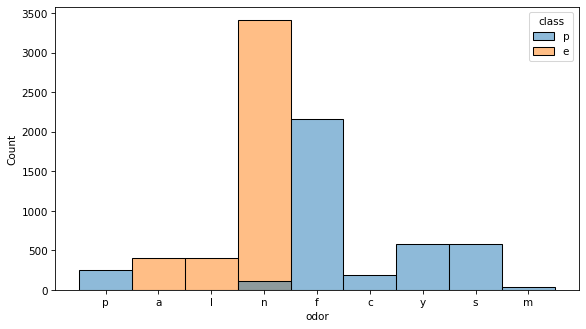

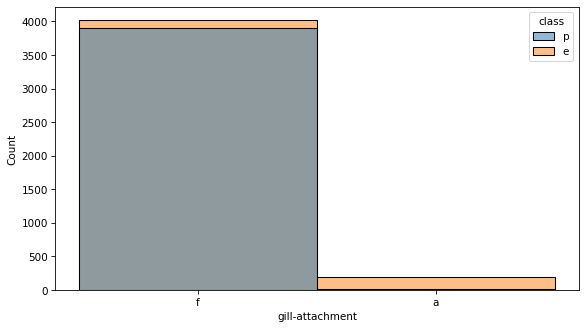

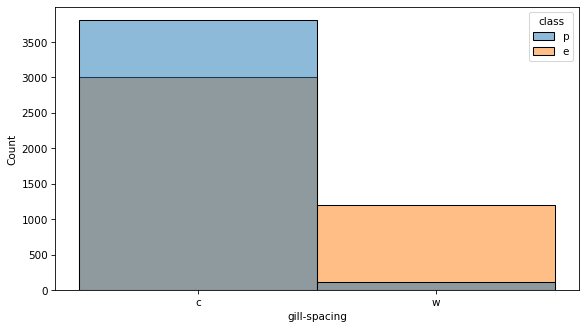

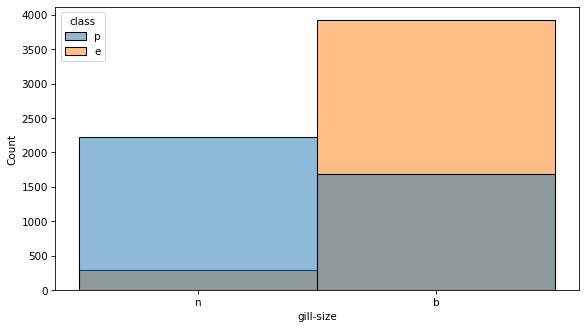

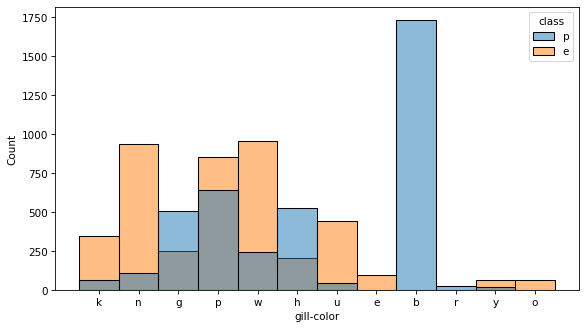

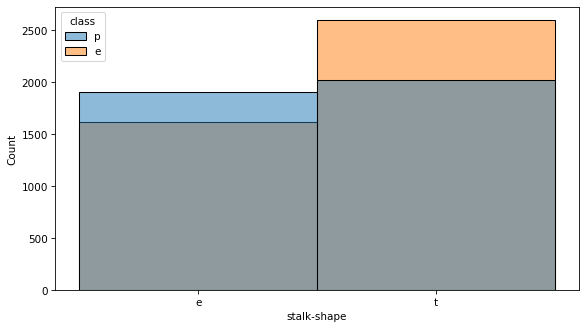

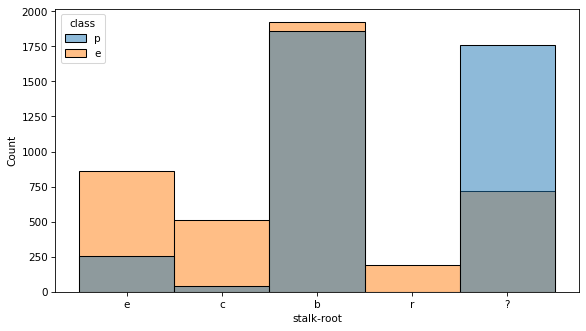

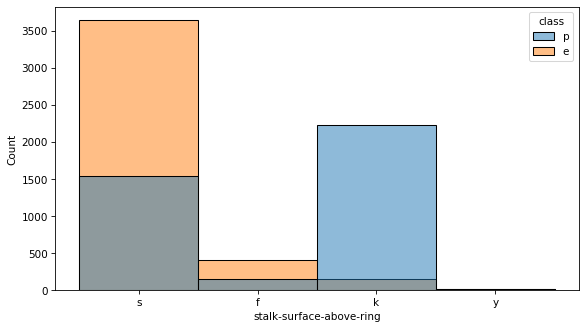

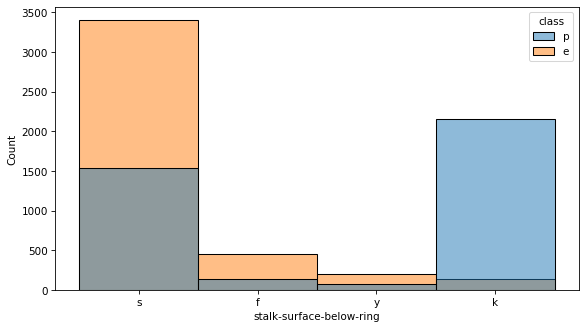

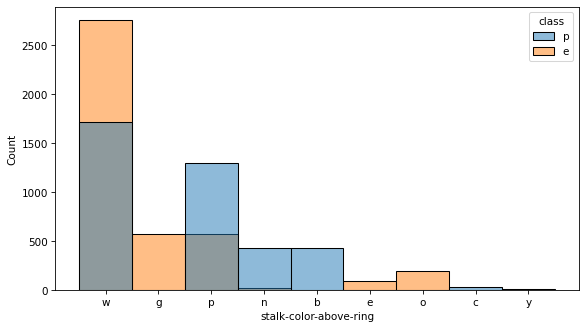

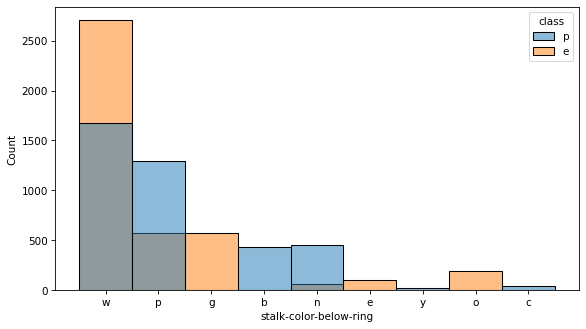

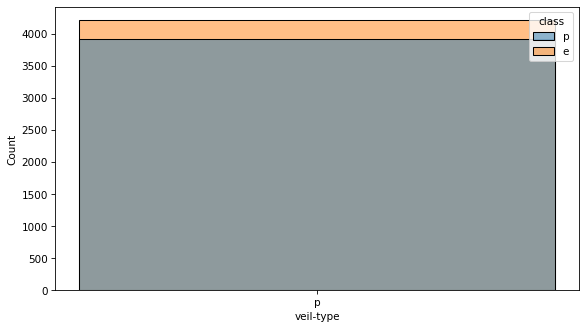

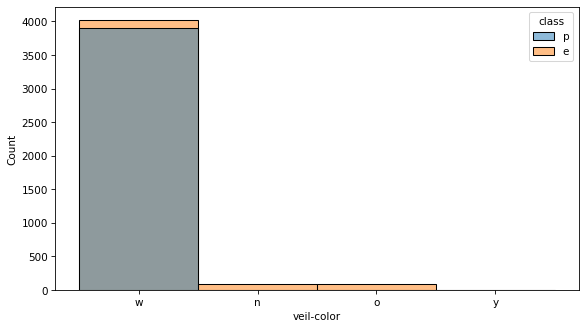

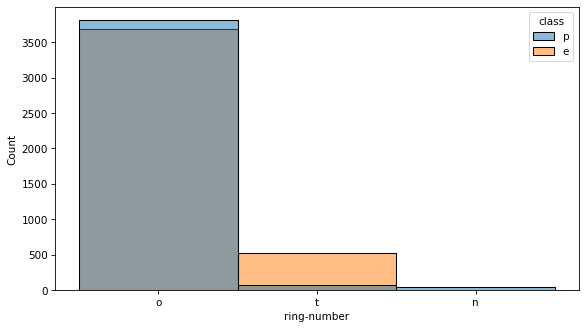

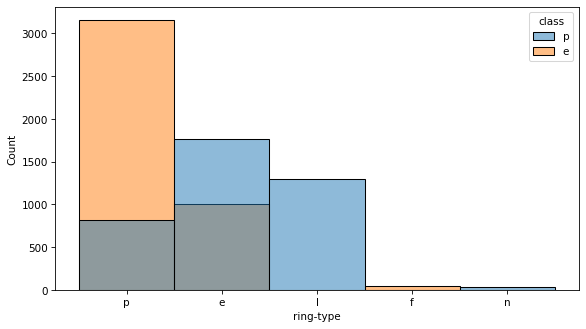

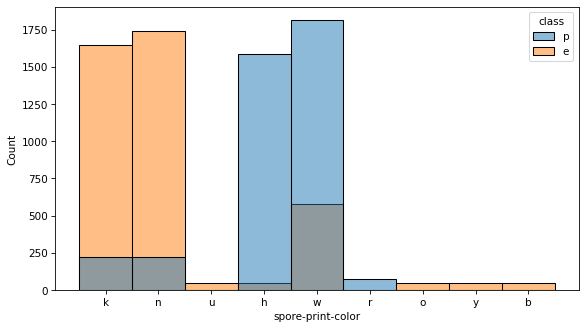

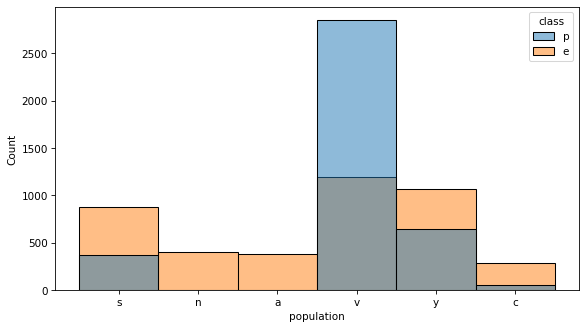

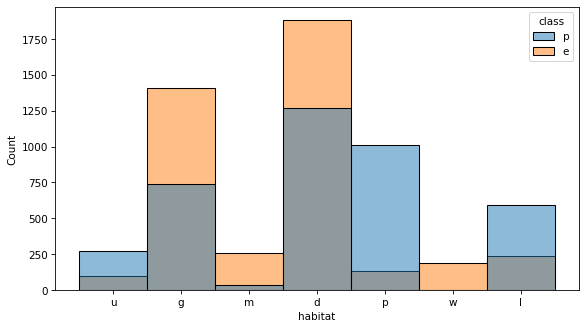

In [5]:
# create histograms to visualize distributions of each feature grouped by the target 

for column in mushrooms.columns:
    plt.figure(figsize=(9,5), dpi=75)
    sns.histplot(mushrooms, x=column, hue='class')

In [6]:
dummy_features = mushroom_dummies.drop(columns=['class_edible','class_poisonous'])

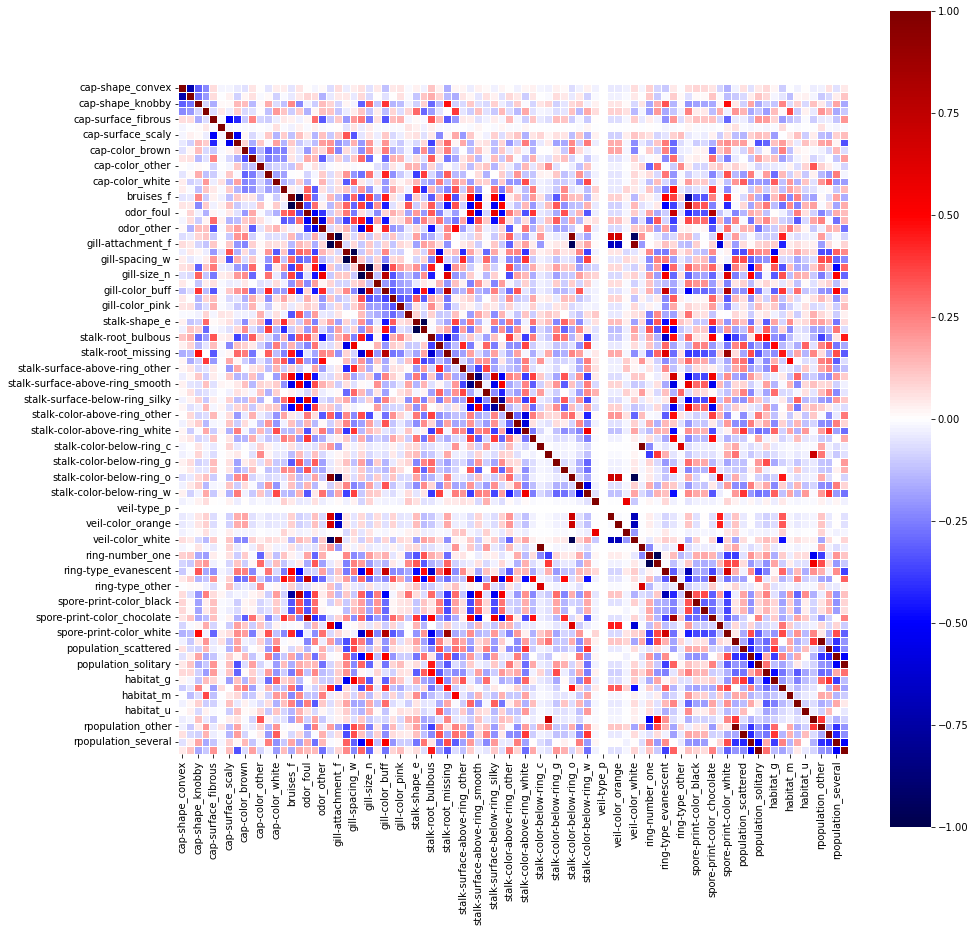

In [7]:
# create a heatmap of the dummy data

plt.figure(figsize=(15,15))
sns.heatmap(dummy_features.corr(), center=0, cmap='seismic', square=True, linewidth=-1, vmax=1);

In [8]:
# find the features that are highly correlated
cor_matrix = dummy_features.corr().abs()
#print(cor_matrix)

# focus on the upper triangle
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

# create a list of highly correlated features
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

for feat in to_drop:
    print(feat)

bruises_t
gill-attachment_f
gill-spacing_w
gill-size_n
stalk-shape_t
stalk-color-below-ring_o
veil-color_white
ring-number_none
ring-number_two
rpopulation_other
rpopulation_scattered
rpopulation_several
rpopulation_solitary


In [9]:
mushroom_dummies_noncorrelation = dummy_features.drop(columns=to_drop, axis=1)

In [10]:
mushroom_dummies_noncorrelation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   cap-shape_convex                 8124 non-null   int64
 1   cap-shape_flat                   8124 non-null   int64
 2   cap-shape_knobby                 8124 non-null   int64
 3   cap-shape_other                  8124 non-null   int64
 4   cap-surface_fibrous              8124 non-null   int64
 5   cap-surface_other                8124 non-null   int64
 6   cap-surface_scaly                8124 non-null   int64
 7   cap-surface_smooth               8124 non-null   int64
 8   cap-color_brown                  8124 non-null   int64
 9   cap-color_gray                   8124 non-null   int64
 10  cap-color_other                  8124 non-null   int64
 11  cap-color_red                    8124 non-null   int64
 12  cap-color_white                  8124 non-null  

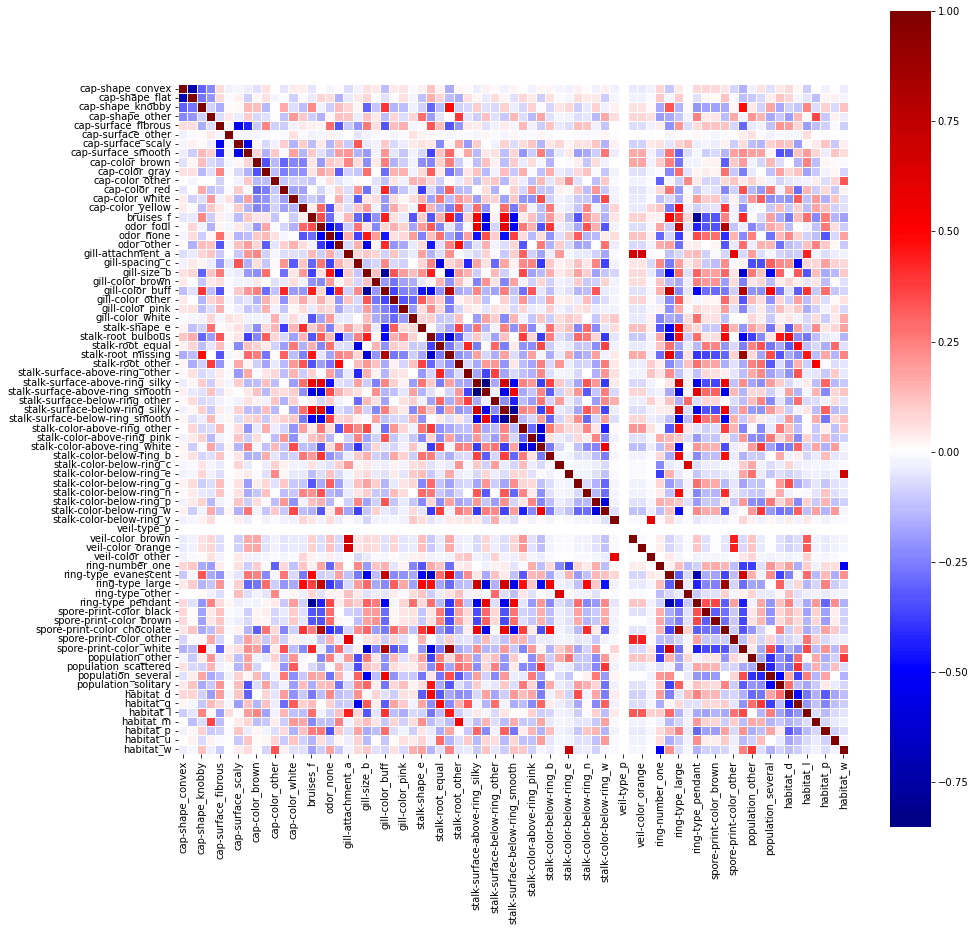

In [11]:
# create a heatmap of the cleaned up dummy data

# create a heatmap of the dummy data

plt.figure(figsize=(15,15))
sns.heatmap(mushroom_dummies_noncorrelation.corr(), center=0, cmap='seismic', square=True, linewidth=-1, vmax=1);

In [12]:
# create features set and target

X = mushroom_dummies_noncorrelation
y = mushrooms[['class']]
y_dummy = mushroom_dummies[['class_edible','class_poisonous']]

# make a random subset of features
X_names = list(mushroom_dummies_noncorrelation)
#n = 5
#random_features = []
#random_features.append(random.sample(X_names, n))
#X = mushroom_dummies_noncorrelation[random_features]

# X with random features
#X = mushroom_dummies_noncorrelation[['cap-shape_knobby','gill-size_b','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['stalk-root_equal','spore-print-color_brown','habitat_d']]
#X = mushroom_dummies_noncorrelation[['odor_none','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['bruises_f','odor_none','spore-print-color_brown']]

# convert target to binary

target_map = {'p':1, 'e':0}
y['class'] = y['class'].map(target_map)

# split the data 80/20 for logistic regression, knn, and decision tree models

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)

In [13]:
#random_features

In [14]:
#X.info()

In [15]:
# logistic regression

lr = LogisticRegression(max_iter=8000)

lr.fit(X_train, y_train.values.ravel())

y_preds = lr.predict(X_train)
y_probs = lr.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [   5 3137]]
Training AUC: 99.9990 %
Training accuracy: 99.9231 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3357
           1       1.00      1.00      1.00      3142

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499



In [16]:
# testing on lr

y_preds_test = lr.predict(X_test)
y_probs_test = lr.predict_proba(X_test)[:,1]

train_accuracy = metrics.accuracy_score(y_test, y_preds_test)*100
train_auc_roc = metrics.roc_auc_score(y_test, y_probs_test)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_preds_test))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_test, y_preds_test))

Confusion matrix:
 [[851   0]
 [  3 771]]
Training AUC: 99.9994 %
Training accuracy: 99.8154 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       774

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



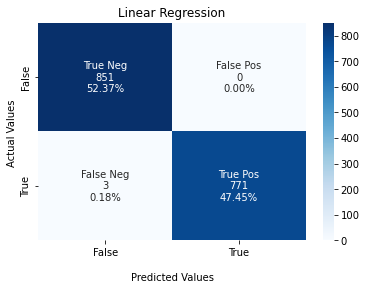

<Figure size 432x288 with 0 Axes>

In [17]:
y_preds = lr.predict(X_test)
y_probs = lr.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Linear Regression');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('lr_confusion.png')

In [18]:
# cross-validate the model

scores = cross_val_score(lr, y_test, y_preds, cv=10, scoring='accuracy')
print(scores)

[1.         0.99386503 1.         0.99386503 1.         1.
 1.         0.99382716 1.         1.        ]


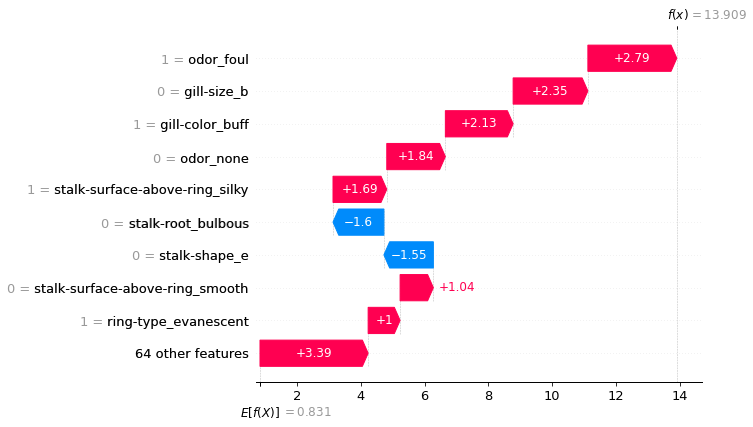

In [19]:
# print the JS visualization code to the notebook
shap.initjs()

# instantiate SHAP values explainer

lr_shap = lr.fit(X_train, y_train)
lr_explainer = shap.LinearExplainer(lr_shap, X_train)
shap_values = lr_explainer(X_train)

# visualize SHAP

shap.plots.waterfall(shap_values[99])

In [20]:
# knn

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train.values.ravel())

y_preds = knn.predict(X_train)
y_probs = knn.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [   0 3142]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3357
           1       1.00      1.00      1.00      3142

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499



In [21]:
# testing on knn

y_preds_test = knn.predict(X_test)
y_probs_test = knn.predict_proba(X_test)[:,1]

train_accuracy = metrics.accuracy_score(y_test, y_preds_test)*100
train_auc_roc = metrics.roc_auc_score(y_test, y_probs_test)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_preds_test))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_test, y_preds_test))

Confusion matrix:
 [[851   0]
 [  0 774]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       774

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [22]:
# cross-validate the model

scores = cross_val_score(knn, y_test, y_preds_test, cv=10, scoring='accuracy')
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


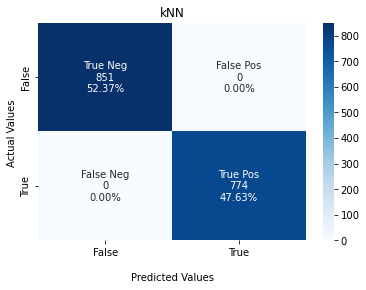

<Figure size 432x288 with 0 Axes>

In [23]:
y_preds = knn.predict(X_test)
y_probs = knn.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('kNN');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('knn_confusion.png')

In [24]:
# decision tree

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

y_preds = tree.predict(X_train)
y_probs = tree.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [   0 3142]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3357
           1       1.00      1.00      1.00      3142

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499



In [25]:
# testing on tree

y_preds_test = tree.predict(X_test)
y_probs_test = tree.predict_proba(X_test)[:,1]

train_accuracy = metrics.accuracy_score(y_test, y_preds_test)*100
train_auc_roc = metrics.roc_auc_score(y_test, y_probs_test)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_preds_test))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_test, y_preds_test))

Confusion matrix:
 [[851   0]
 [  0 774]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       1.00      1.00      1.00       774

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [26]:
# cross-validate the model

scores = cross_val_score(tree, y_test, y_preds_test, cv=10, scoring='accuracy')
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


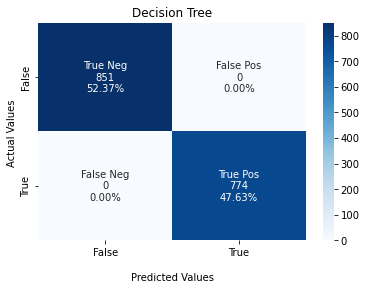

<Figure size 432x288 with 0 Axes>

In [27]:
y_preds = tree.predict(X_test)
y_probs = tree.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Decision Tree');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('dt_confusion.png')

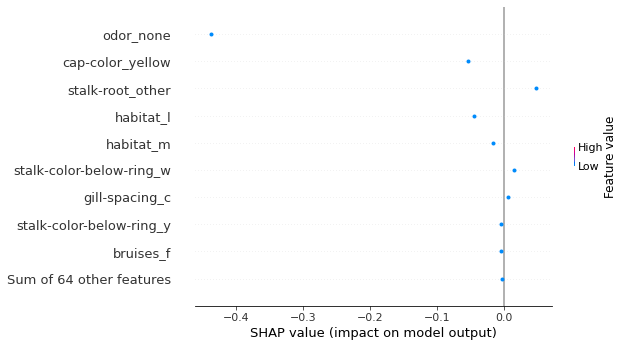

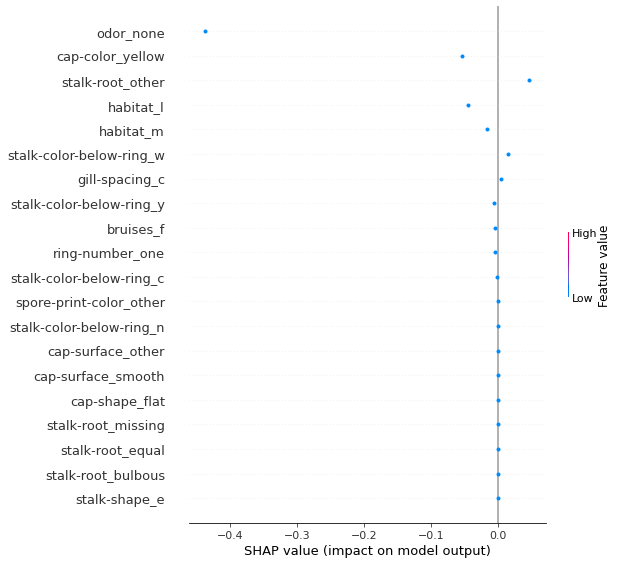

In [28]:
# print the JS visualization code to the notebook
shap.initjs()

# test_x is a np.ndarray with (2936911, 41) shape
df_tmp = pd.DataFrame(X, columns=X_names)

masker = shap.maskers.Independent(df_tmp, max_samples=1000)
explainer = shap.TreeExplainer(tree, masker)

# shap_values.values.shape ==  (10000, 41, 2)
# shap_values[1].values.shape == (41, 2)
shap_values = explainer(df_tmp.sample(random_state=69))

# tmp.values.shape == tmp.data.shape == (10000, 41)
# I took all observations for all features just for positive prediction result
tmp = shap.Explanation(shap_values[:, :, 1], data=df_tmp, feature_names=X_names)

# now both plots work
shap.plots.beeswarm(tmp)
shap.summary_plot(tmp)
#shap.plots.bar(tmp)

In [29]:
# random forest

rf = RandomForestClassifier()

rf.fit(X_train, y_train.values.ravel())

y_preds = rf.predict(X_train)
y_probs = tree.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [   0 3142]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3357
           1       1.00      1.00      1.00      3142

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499



In [30]:
scores = cross_val_score(rf, y_train, y_preds, cv=10, scoring='accuracy')
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


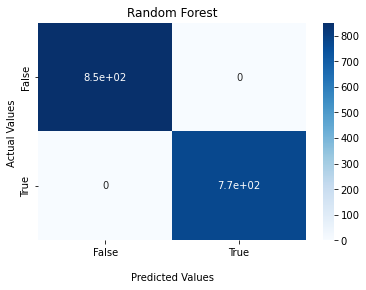

<Figure size 432x288 with 0 Axes>

In [31]:
y_preds = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds_test)

ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Random Forest');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('rf_confusion.png')

In [32]:
# cross validation?

In [33]:
# naive bayes to determine likelihood of seeing a particular set of features for poisonous mushrooms?

In [34]:
# how do i demonstrate feature importance mathematically?

In [35]:
# look at ROC curves for new models to identify good values for precision and/or recall
# look at example of changing the decision threshold for different classifiers

In [36]:
## moving forward with the tree model, reducing feature numbers

# recreate features set and target

X = mushroom_dummies_noncorrelation[['odor_none','cap-color_yellow','habitat_p','spore-print-color_chocolate','gill-spacing_c','stalk-root_bulbous','bruises_f']]
y = mushrooms[['class']]

# make a random subset of features
X_names = list(X)
#n = 5
#random_features = []
#random_features.append(random.sample(X_names, n))
#X = mushroom_dummies_noncorrelation[random_features]

# X with random features
#X = mushroom_dummies_noncorrelation[['cap-shape_knobby','gill-size_b','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['stalk-root_equal','spore-print-color_brown','habitat_d']]
#X = mushroom_dummies_noncorrelation[['odor_none','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['bruises_f','odor_none','spore-print-color_brown']]

# convert target to binary

target_map = {'p':1, 'e':0}
y['class'] = y['class'].map(target_map)

# split the data 80/20 for logistic regression, knn, and decision tree models

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)

In [37]:
# decision tree

final_model = DecisionTreeClassifier()

final_model.fit(X_train, y_train)

y_preds = final_model.predict(X_train)
y_probs = final_model.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [ 264 2878]]
Training AUC: 99.2122 %
Training accuracy: 95.9378 %
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3357
           1       1.00      0.92      0.96      3142

    accuracy                           0.96      6499
   macro avg       0.96      0.96      0.96      6499
weighted avg       0.96      0.96      0.96      6499



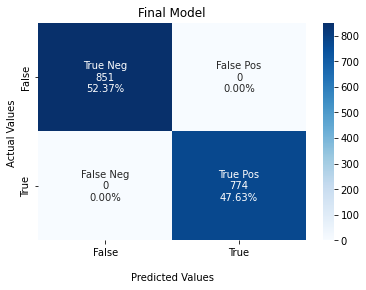

<Figure size 432x288 with 0 Axes>

In [38]:
y_preds = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Final Model');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('final_dt_confusion.png')

In [39]:
# recreate features set and target

X_simple = mushroom_dummies[['gill-color_buff','ring-type_large','odor_foul','stalk-root_bulbous']]
y_simple = mushrooms[['class']]

# make a random subset of features
X_names = list(X_simple)
#n = 5
#random_features = []
#random_features.append(random.sample(X_names, n))
#X = mushroom_dummies_noncorrelation[random_features]

# X with random features
#X = mushroom_dummies_noncorrelation[['cap-shape_knobby','gill-size_b','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['stalk-root_equal','spore-print-color_brown','habitat_d']]
#X = mushroom_dummies_noncorrelation[['odor_none','veil-type_p']]
#X = mushroom_dummies_noncorrelation[['bruises_f','odor_none','spore-print-color_brown']]

# convert target to binary

target_map = {'p':1, 'e':0}
y_simple['class'] = y_simple['class'].map(target_map)

# split the data 80/20 for logistic regression, knn, and decision tree models

X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, train_size=0.8,test_size=0.2, random_state=101)

In [40]:
# decision tree

final_model_simple = DecisionTreeClassifier()

final_model_simple.fit(X_train, y_train)

y_preds = final_model_simple.predict(X_train)
y_probs = final_model_simple.predict_proba(X_train)[:,1]

train_accuracy = metrics.accuracy_score(y_train, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_train, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_train, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_train, y_preds))

Confusion matrix:
 [[3357    0]
 [ 485 2657]]
Training AUC: 92.3078 %
Training accuracy: 92.5373 %
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3357
           1       1.00      0.85      0.92      3142

    accuracy                           0.93      6499
   macro avg       0.94      0.92      0.92      6499
weighted avg       0.93      0.93      0.92      6499



In [46]:
y_preds = final_model_simple.predict(X_test)
y_probs = final_model_simple.predict_proba(X_test)[:,1]

train_accuracy = metrics.accuracy_score(y_test, y_preds)*100
train_auc_roc = metrics.roc_auc_score(y_test, y_probs)*100

print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_preds))
print('Training AUC: %.4f %%' % train_auc_roc)
print('Training accuracy: %.4f %%' % train_accuracy)
print(metrics.classification_report(y_test, y_preds))

Confusion matrix:
 [[851   0]
 [119 655]]
Training AUC: 92.4403 %
Training accuracy: 92.6769 %
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       851
           1       1.00      0.85      0.92       774

    accuracy                           0.93      1625
   macro avg       0.94      0.92      0.93      1625
weighted avg       0.94      0.93      0.93      1625



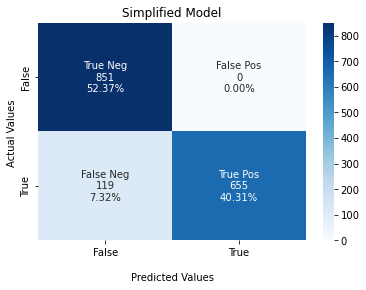

<Figure size 432x288 with 0 Axes>

In [41]:
y_preds = final_model_simple.predict(X_test)
y_probs = final_model_simple.predict_proba(X_test)[:,1]
matrix = metrics.confusion_matrix(y_test, y_preds)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Simplified Model');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## save the figure
plt.savefig('final_dt__simple_confusion.png')

In [45]:
# cross-validate the model

acc = cross_val_score(final_model_simple, y_test, y_preds, cv=10, scoring='accuracy')
print(f'Accuracy: {np.mean(acc)}')

recall = cross_val_score(final_model_simple, y_test, y_preds, cv=10, scoring='recall')
print(f'Recall: {np.mean(recall)}')

pre = cross_val_score(final_model_simple, y_test, y_preds, cv=10, scoring='precision')
print(f'Precision: {np.mean(pre)}')

Accuracy: 0.9267325607816405
Recall: 1.0
Precision: 0.8474564698211895


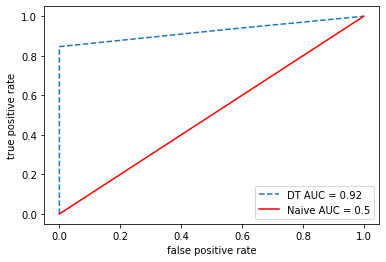

<Figure size 432x288 with 0 Axes>

In [43]:
y_pred_proba = final_model_simple.predict_proba(X_test)[:, 1]

fpr,tpr,_ = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr, tpr, ls= '--', label='DT AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0,1], c='r', label='Naive AUC = 0.5')
plt.legend(loc='lower right')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()

## save the figure
plt.savefig('simple_tree_auc.png')

In [44]:
classes = ['poisonous','edible']

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_model_simple, 
                   feature_names=X_names,  
                   class_names=classes,
                   filled=True)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'plot_tree'

<Figure size 1800x1440 with 0 Axes>